# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Connect to database

In [2]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [4]:
query="""
    select *
    from agg.tidy_data_30min 
    where site = 64
"""

In [5]:
df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_227096\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17539 entries, 0 to 17538
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  17539 non-null  datetime64[ns, UTC]
 1   site                       17539 non-null  int64              
 2   year                       17539 non-null  int64              
 3   month                      17539 non-null  int64              
 4   day                        17539 non-null  int64              
 5   hour                       17539 non-null  int64              
 6   minute                     17539 non-null  int64              
 7   day_of_week                17539 non-null  int64              
 8   season                     17539 non-null  int64              
 9   net_load                   17539 non-null  float64            
 10  precipitation              17045 non-null  float64            
 11  pr

In [7]:
df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
0,2019-11-23 20:30:00+00:00,64,2019,11,23,21,30,5,4,28.84,...,NaN,NaN,NaN,NaN,NaN,464.21,151.0825,544.78,298.38,1
1,2019-04-23 15:00:00+00:00,64,2019,4,23,16,0,1,2,-177.55,...,NaN,NaN,NaN,NaN,NaN,-27.63,-75.8800,12.71,2.03,0
2,2019-04-23 15:30:00+00:00,64,2019,4,23,16,30,1,2,4.58,...,NaN,NaN,NaN,NaN,NaN,-24.74,-34.7600,16.66,5.71,0
3,2019-04-23 16:00:00+00:00,64,2019,4,23,17,0,1,2,14.70,...,NaN,NaN,NaN,NaN,NaN,5.20,-11.6750,17.73,9.42,0
4,2019-04-23 16:30:00+00:00,64,2019,4,23,17,30,1,2,12.82,...,NaN,NaN,NaN,NaN,NaN,28.17,5.0250,28.62,15.78,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17534,2020-03-30 09:00:00+00:00,64,2020,3,30,10,0,0,2,11.33,...,NaN,NaN,NaN,NaN,NaN,-18.76,-20.7500,35.43,7.21,0
17535,2020-03-30 09:30:00+00:00,64,2020,3,30,10,30,0,2,8.46,...,NaN,NaN,NaN,NaN,NaN,21.09,-68.9825,65.76,6.49,0
17536,2020-03-30 10:00:00+00:00,64,2020,3,30,11,0,0,2,0.22,...,NaN,NaN,NaN,NaN,NaN,-43.60,-146.5200,85.88,8.58,0
17537,2020-03-30 10:30:00+00:00,64,2020,3,30,11,30,0,2,-5.47,...,NaN,NaN,NaN,NaN,NaN,-122.59,-169.0875,26.46,-1.58,0


In [8]:
# Convert 'ts' to datetime and set as index
# df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.set_index('timestamp', drop=False)
df = df.sort_index()

df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,2019-04-01 00:00:00+00:00,64,2019,4,1,1,0,0,2,14.620,...,2.0,97.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0
2019-04-01 00:30:00+00:00,2019-04-01 00:30:00+00:00,64,2019,4,1,1,30,0,2,16.700,...,2.0,97.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0
2019-04-01 01:00:00+00:00,2019-04-01 01:00:00+00:00,64,2019,4,1,2,0,0,2,20.270,...,3.0,99.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0
2019-04-01 01:30:00+00:00,2019-04-01 01:30:00+00:00,64,2019,4,1,2,30,0,2,15.870,...,3.0,99.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0
2019-04-01 02:00:00+00:00,2019-04-01 02:00:00+00:00,64,2019,4,1,3,0,0,2,15.120,...,6.0,100.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,2020-03-31 20:30:00+00:00,64,2020,3,31,21,30,1,2,14.390,...,NaN,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0
2020-03-31 21:00:00+00:00,2020-03-31 21:00:00+00:00,64,2020,3,31,22,0,1,2,14.710,...,NaN,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0
2020-03-31 21:30:00+00:00,2020-03-31 21:30:00+00:00,64,2020,3,31,22,30,1,2,14.950,...,NaN,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0


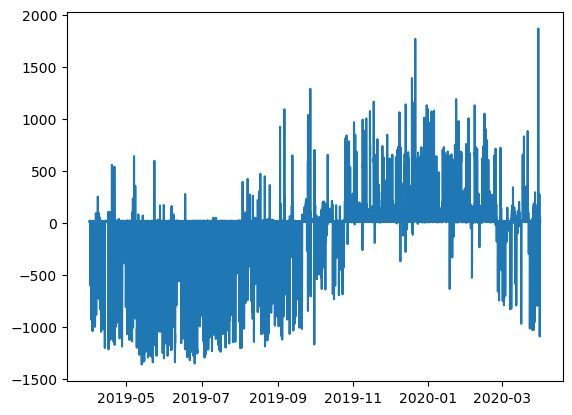

In [9]:
plt.plot(df.index, df.net_load)
plt.show()

# Normalise net load (as seen in literature)

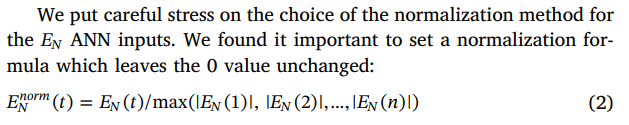



High-resolution net load forecasting for micro-neighbourhoods with high
penetration of renewable energy sources
P. Kobylinskia
, M. Wierzbowskia
, K. Piotrowskib,

In [10]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday,net_load_norm
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,2019-04-01 00:00:00+00:00,64,2019,4,1,1,0,0,2,14.620,...,97.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0,0.007819
2019-04-01 00:30:00+00:00,2019-04-01 00:30:00+00:00,64,2019,4,1,1,30,0,2,16.700,...,97.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0,0.008931
2019-04-01 01:00:00+00:00,2019-04-01 01:00:00+00:00,64,2019,4,1,2,0,0,2,20.270,...,99.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0,0.010840
2019-04-01 01:30:00+00:00,2019-04-01 01:30:00+00:00,64,2019,4,1,2,30,0,2,15.870,...,99.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0,0.008487
2019-04-01 02:00:00+00:00,2019-04-01 02:00:00+00:00,64,2019,4,1,3,0,0,2,15.120,...,100.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0,0.008086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,2020-03-31 20:30:00+00:00,64,2020,3,31,21,30,1,2,14.390,...,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0,0.007696
2020-03-31 21:00:00+00:00,2020-03-31 21:00:00+00:00,64,2020,3,31,22,0,1,2,14.710,...,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0,0.007867
2020-03-31 21:30:00+00:00,2020-03-31 21:30:00+00:00,64,2020,3,31,22,30,1,2,14.950,...,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0,0.007995


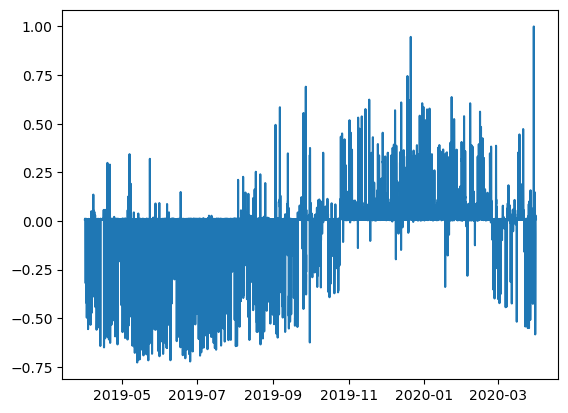

In [11]:
plt.plot(df.index, df.net_load_norm)
plt.show()

# Prepare data set for LSTM

Example \
Based on the first 5 hours, let's predict the 6th hour\
Based on the next 5 hours, let's predict the 7th hour\
etc. etc.

[[[1], [2], [3], [4], [5]]] [6] \
[[[2], [3], [4], [5], [6]]] [7] \
[[[3], [4], [5], [6], [7]]] [8]

### Set parameters

In [35]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 3 hours = 2 * 3 = 6
# 1 hours = 2 * 1 = 2 

n_input = 6
n_features = 4
n_output = 2


# Select which features are to be inputted into the LSTM i.e., which columns in the df
df_input = df[['net_load']]
df_input

,net_load
timestamp,
2019-04-01 00:00:00+00:00,14.620
2019-04-01 00:30:00+00:00,16.700
2019-04-01 01:00:00+00:00,20.270
2019-04-01 01:30:00+00:00,15.870
2019-04-01 02:00:00+00:00,15.120
...,...
2020-03-31 20:30:00+00:00,14.390
2020-03-31 21:00:00+00:00,14.710
2020-03-31 21:30:00+00:00,14.950


### Create lag values

In [36]:
lags = [1, 2, 3]
for lag in lags:
    df_input[f'net_load_lag{lag}'] = df['net_load'].shift(lag)

C:\Users\elian\AppData\Local\Temp\ipykernel_227096\3936076829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[f'net_load_lag{lag}'] = df['net_load'].shift(lag)
C:\Users\elian\AppData\Local\Temp\ipykernel_227096\3936076829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[f'net_load_lag{lag}'] = df['net_load'].shift(lag)
C:\Users\elian\AppData\Local\Temp\ipykernel_227096\3936076829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [37]:
df_input.dropna(inplace=True)
df_input

C:\Users\elian\AppData\Local\Temp\ipykernel_227096\4020501280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.dropna(inplace=True)


,net_load,net_load_lag1,net_load_lag2,net_load_lag3
timestamp,,,,
2019-04-01 01:30:00+00:00,15.870,20.27,16.70,14.62
2019-04-01 02:00:00+00:00,15.120,15.87,20.27,16.70
2019-04-01 02:30:00+00:00,21.760,15.12,15.87,20.27
2019-04-01 03:00:00+00:00,22.530,21.76,15.12,15.87
2019-04-01 03:30:00+00:00,15.630,22.53,21.76,15.12
...,...,...,...,...
2020-03-31 20:30:00+00:00,14.390,14.70,14.87,14.95
2020-03-31 21:00:00+00:00,14.710,14.39,14.70,14.87
2020-03-31 21:30:00+00:00,14.950,14.71,14.39,14.70


In [38]:
# # Define a function for normalization
# def normalize_dataframe(df):
#     normalized_df = df.copy()
#     for column in df.columns:
#         max_value = df[column].abs().max()
#         normalized_df[column] = df[column] / max_value
#     return normalized_df

# df_input_scaled = normalize_dataframe(df_input)
# df_input_scaled


scaler = StandardScaler()
df_input_scaled = pd.DataFrame(scaler.fit_transform(df_input), columns=df_input.columns)
df_input_scaled

,net_load,net_load_lag1,net_load_lag2,net_load_lag3
0,0.195343,0.210612,0.198222,0.191003
1,0.192740,0.195342,0.210612,0.198222
2,0.215784,0.192739,0.195341,0.210612
3,0.218456,0.215783,0.192739,0.195342
4,0.194510,0.218455,0.215783,0.192739
...,...,...,...,...
17531,0.190206,0.191281,0.191871,0.192149
17532,0.191317,0.190206,0.191281,0.191871
17533,0.192150,0.191316,0.190205,0.191281
17534,0.192115,0.192149,0.191316,0.190205


<Axes: >

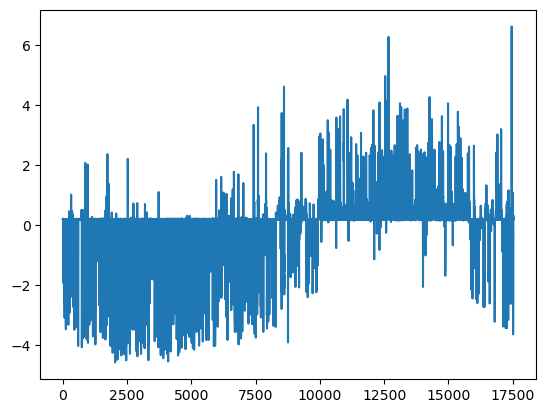

In [39]:
df_input_scaled['net_load'].plot()

In [ ]:
df_input_scaled['season'].plot()

In [ ]:
df_input_scaled['month'].plot()

### Generate the X and y matrices

In [40]:
# X, y = [], []
# for i in range(len(df_input) - n_input - n_output + 1):
#     X.append(df_input[i:(i + n_input), 0])
#     y.append(df_input['net_load_norm'][(i + n_input):(i + n_input + n_output), 0])

# X = np.array(X).reshape((len(X), n_input, n_features))
# y = np.array(y)


# X, y = [], []
# for i in range(n_input, len(df_input) - n_output + 1):
#     X.append(df_input[i - n_input : i,0 : df_input.shape[1]])
#     y.append(df_input[i + n_output - 1 : i + n_output, 0])

# X = np.array(X).reshape((len(X), n_input, n_features))
# y = np.array(y)

# X, y = [], []
# for i in range(len(df_input) - n_input - n_output + 1):
#     X.append(df_input.iloc[i:(i + n_input), 0].values)  # Assuming 0 is the correct column index
#     y.append(df_input['net_load_norm'].iloc[i + n_input:i + n_input + n_output].values)

# X = np.array(X).reshape((len(X), n_input, -1))  # Adjusted for n_features
# y = np.array(y)

X, y = [], []
for i in range(len(df_input_scaled) - n_input - n_output + 1):
    # Select all columns for the input sequence
    X.append(df_input_scaled.iloc[i:(i + n_input)].values)  
    
    y.append(df_input_scaled['net_load'].iloc[(i + n_input):(i + n_input + n_output)].values)

X = np.array(X).reshape((len(X), n_input, -1))  
y = np.array(y)

In [41]:
X.shape

(17529, 6, 4)

In [42]:
y.shape

(17529, 2)

First set of X and y values

In [43]:
print(f'Given the array X: \n {X[0]}\n')
print(f'Predict this y: \n {y[0]}\n')

Given the array X: 
 [[0.19534272 0.21061192 0.19822198 0.19100347]
 [0.19273987 0.19534185 0.21061156 0.19822205]
 [0.2157838  0.192739   0.19534149 0.21061163]
 [0.21845606 0.21578293 0.19273863 0.19534156]
 [0.19450981 0.21845519 0.21578256 0.1927387 ]
 [0.19190695 0.19450894 0.21845483 0.21578263]]

Predict this y: 
 [0.19208048 0.19256634]



Second set of X and y values

In [44]:
print(f'Given the array X: \n {X[1].flatten()}\n')
print(f'Predict this y: \n {y[1]}\n')

Given the array X: 
 [0.19273987 0.19534185 0.21061156 0.19822205 0.2157838  0.192739
 0.19534149 0.21061163 0.21845606 0.21578293 0.19273863 0.19534156
 0.19450981 0.21845519 0.21578256 0.1927387  0.19190695 0.19450894
 0.21845483 0.21578263 0.19208048 0.19190608 0.19450858 0.21845489]

Predict this y: 
 [0.19256634 0.18902646]



In [47]:
df_input_scaled[0:10]

,net_load,net_load_lag1,net_load_lag2,net_load_lag3
0,0.195343,0.210612,0.198222,0.191003
1,0.192740,0.195342,0.210612,0.198222
2,0.215784,0.192739,0.195341,0.210612
3,0.218456,0.215783,0.192739,0.195342
4,0.194510,0.218455,0.215783,0.192739
5,0.191907,0.194509,0.218455,0.215783
6,0.192080,0.191906,0.194509,0.218455
7,0.192566,0.192080,0.191906,0.194509
8,0.189026,0.192565,0.192079,0.191906
9,0.187326,0.189026,0.192565,0.192079


# Split into train (First 300 days) and test (the rest i.e., ~60 days depending on how big the n_input variable is set )

In [ ]:
# 1 time step = 30 mins

n_split = 2 * 24 * 300 

X_train = X[:n_split]
y_train = y[:n_split]

X_test = X[n_split:]
y_test = y[n_split:]

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape

# Build LSTM model

### Model 1

In [ ]:
model1 = Sequential()
model1.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model1.add(LSTM(64, activation='relu', return_sequences=True ))
model1.add(LSTM(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(y_train.shape[1]))

model1.summary()

In [ ]:
cp1 = ModelCheckpoint('model2.keras', save_best_only=True)
model1.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[MeanSquaredError(), MeanAbsoluteError()])

# Fit LSTM model

In [ ]:
# history = model1.fit(X_train, y_train, epochs=10, callbacks=[cp1], batch_size=16, validation_split=0.1)
history = model1.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1)

# Check training results

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Plot training results

In [ ]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_train_input = X_train[::n_output]
y_train_input = y_train[::n_output]

In [ ]:
X_train_input.shape

In [ ]:
y_train_input.shape

In [ ]:
print(f"n_ouput: {n_output}")

In [ ]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 1000
end_section = 1100
diff = end_section-start_section


predictions = []

for i in X_train_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Training Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_train_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Net Load (-)')

xcoords = [(i*n_output)-1+n_output for i in range(diff)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()

# Plot testing results

In [ ]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_test_input = X_test[::n_output]
y_test_input = y_test[::n_output]

In [ ]:
X_test_input.shape

In [ ]:
y_test_input.shape

In [ ]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 0
end_section = 10
diff = end_section-start_section


predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Testing Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_test_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Net Load (-)')

xcoords = [(i*n_output)-1+n_output for i in range(diff)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()